#Imports

In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
from sklearn.preprocessing import StandardScaler
from torch.utils.data import Dataset

#Data Preprocessing

In [2]:
# Load the dataset using Pandas
data = pd.read_csv('diabetes.csv')
data.head()

,Number of times pregnant,Plasma glucose concentration,Diastolic blood pressure,Triceps skin fold thickness,2-Hour serum insulin,Body mass index,Age,Class
0,6,148,72,35,0,33.6,50,positive
1,1,85,66,29,0,26.6,31,negative
2,8,183,64,0,0,23.3,32,positive
3,1,89,66,23,94,28.1,21,negative
4,0,137,40,35,168,43.1,33,positive


In [3]:
# For x: Extract out the dataset from all the rows (all samples) and all columns except last column (all features). 
# For y: Extract out the last column (which is the label)
# Convert both to numpy using the .values method
x = data.iloc[:,0:-1].values
y_string= list(data.iloc[:,-1])

In [4]:
# Lets have a look some samples from our data
print(x[:3])
print(y_string[:3])
print(x.shape,len(y_string))

[[  6.  148.   72.   35.    0.   33.6  50. ]
 [  1.   85.   66.   29.    0.   26.6  31. ]
 [  8.  183.   64.    0.    0.   23.3  32. ]]
['positive', 'negative', 'positive']
(768, 7) 768


In [5]:
# Our neural network only understand numbers! So convert the string to labels
y_int = []
for string in y_string:
    if string == 'positive':
        y_int.append(1)
    else:
        y_int.append(0)

In [6]:
# Now convert y to an array
y = np.array(y_int, dtype = 'float64')

#Feature Normalization - All features should have the same range of values (-1,1)

$x^{\prime}=\frac{x-\mu}{\sigma}$

In [7]:
# Feature Normalization. All features should have the same range of values (-1,1)
sc = StandardScaler()
x = sc.fit_transform(x)

In [8]:
# Now we convert the arrays to PyTorch tensors
x = torch.tensor(x)
# We add an extra dimension to convert this array to 2D
y = torch.tensor(y).unsqueeze(1)
print(x.shape)
print(y.shape)

torch.Size([768, 7])
torch.Size([768, 1])


In [9]:
class Dataset(Dataset):

    def __init__(self,x,y):
        self.x = x
        self.y = y
        
    def __getitem__(self,index):
        # Get one item from the dataset
        return self.x[index], self.y[index]
    
    def __len__(self):
        return len(self.x)

In [10]:
dataset = Dataset(x,y)

In [11]:
len(dataset)

768

In [12]:
# Load the data to your dataloader for batch processing and shuffling
train_loader = torch.utils.data.DataLoader(dataset=dataset,
                                           batch_size=32,
                                           shuffle=True)

In [13]:
# Let's have a look at the data loader
print("There is {} batches in the dataset (768 / 32) ".format(len(train_loader)))
for (x,y) in train_loader:
    print("For one iteration (batch), there is:")
    print("Data:    {}".format(x.shape))
    print("Labels:  {}".format(y.shape))
    break

There is 24 batches in the dataset (768 / 32) 
For one iteration (batch), there is:
Data:    torch.Size([32, 7])
Labels:  torch.Size([32, 1])


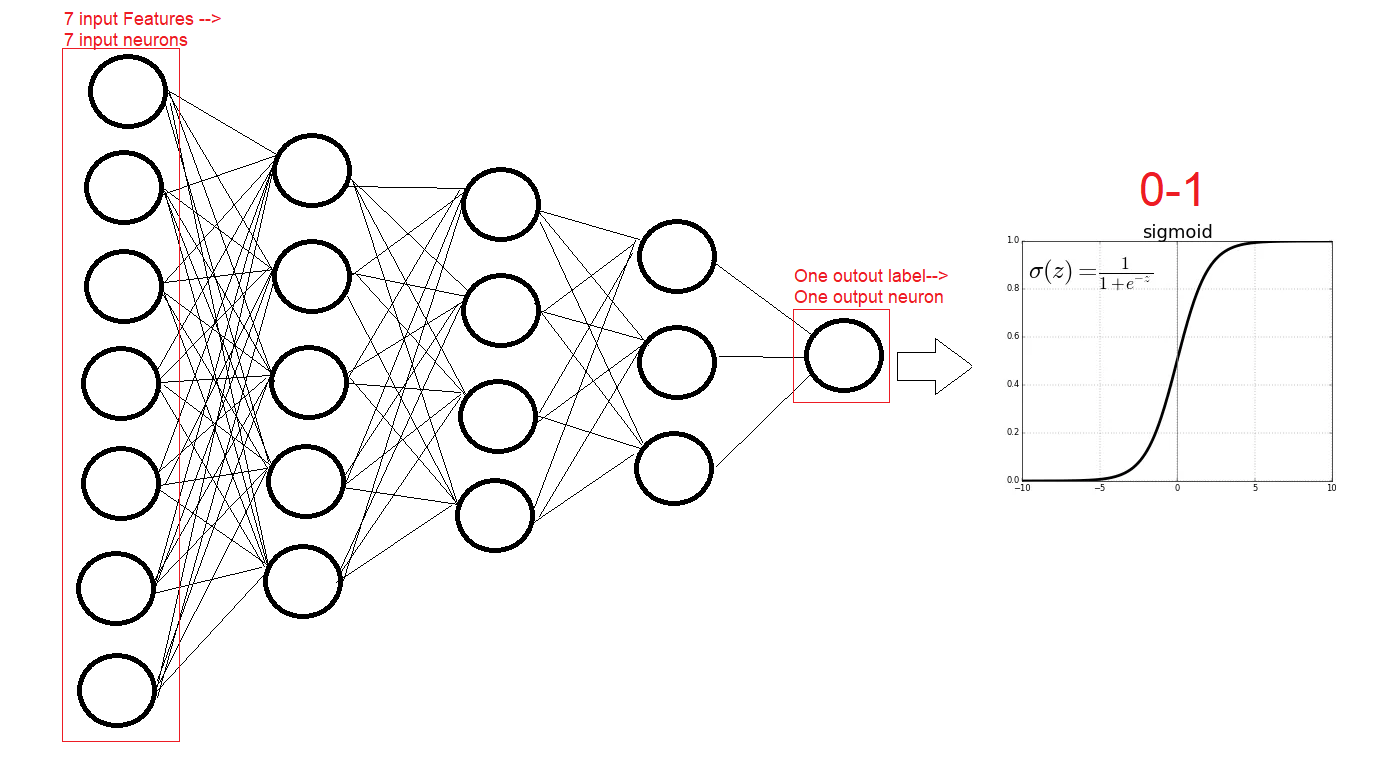

In [14]:
# Now let's build the above network
class Model(nn.Module):
    def __init__(self, input_features):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(input_features, 5)
        self.fc2 = nn.Linear(5, 4)
        self.fc3 = nn.Linear(4, 3)
        self.fc4 = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()
        self.ReLU = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.ReLU(out)
        out = self.fc2(out)
        out = self.ReLU(out)
        out = self.fc3(out)
        out = self.ReLU(out)
        out = self.fc4(out)
        out = self.sigmoid(out)
        return out

In [16]:
# Create the network (an object of the Net class)
net = Model(x.shape[1])
#In Binary Cross Entropy: the input and output should have the same shape 
#size_average = True --> the losses are averaged over observations for each minibatch
criterion = torch.nn.BCELoss(size_average=True)   
# We will use Adam with a learning rate of 0.1
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [17]:
# Train the network 
num_epochs = 400
for epoch in range(num_epochs):
    for inputs,labels in train_loader:
        inputs = inputs.float()
        labels = labels.float()
        # Feed Forward
        output = net(inputs)
        # Loss Calculation
        loss = criterion(output, labels)
        # Clear the gradient buffer (we don't want to accumulate gradients)
        optimizer.zero_grad()
        # Backpropagation 
        loss.backward()
        # Weight Update: w <-- w - lr * gradient
        optimizer.step()
        
    #Accuracy
    # Since we are using a sigmoid, we will need to perform some thresholding
    output = (output>0.5).float()
    # Accuracy: (output == labels).float().sum() / output.shape[0]
    accuracy = (output == labels).float().mean()
    # Print statistics 
    print("Epoch {}/{}, Loss: {:.3f}, Accuracy: {:.3f}".format(epoch+1,num_epochs, loss, accuracy))

Epoch 1/400, Loss: 0.666, Accuracy: 0.656
Epoch 2/400, Loss: 0.670, Accuracy: 0.625
Epoch 3/400, Loss: 0.664, Accuracy: 0.625
Epoch 4/400, Loss: 0.630, Accuracy: 0.719
Epoch 5/400, Loss: 0.616, Accuracy: 0.719
Epoch 6/400, Loss: 0.584, Accuracy: 0.781
Epoch 7/400, Loss: 0.639, Accuracy: 0.594
Epoch 8/400, Loss: 0.590, Accuracy: 0.719
Epoch 9/400, Loss: 0.658, Accuracy: 0.562
Epoch 10/400, Loss: 0.607, Accuracy: 0.625
Epoch 11/400, Loss: 0.518, Accuracy: 0.656
Epoch 12/400, Loss: 0.524, Accuracy: 0.656
Epoch 13/400, Loss: 0.532, Accuracy: 0.594
Epoch 14/400, Loss: 0.745, Accuracy: 0.531
Epoch 15/400, Loss: 0.569, Accuracy: 0.594
Epoch 16/400, Loss: 0.631, Accuracy: 0.562
Epoch 17/400, Loss: 0.528, Accuracy: 0.562
Epoch 18/400, Loss: 0.573, Accuracy: 0.719
Epoch 19/400, Loss: 0.519, Accuracy: 0.656
Epoch 20/400, Loss: 0.498, Accuracy: 0.562
Epoch 21/400, Loss: 0.530, Accuracy: 0.625
Epoch 22/400, Loss: 0.472, Accuracy: 0.719
Epoch 23/400, Loss: 0.470, Accuracy: 0.625
Epoch 24/400, Loss: 